<a href="https://colab.research.google.com/github/alessandropequeno/PPGEEC-Deep-Learning-UFRN/blob/main/Lista2_Quest%C3%A3o_6a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Configurar

In [ ]:
# install imageio para criar as animações.

!pip install imageio

In [ ]:
!pip install scikit-image

In [ ]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-30qnn_m2
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-30qnn_m2
  Resolved https://github.com/tensorflow/docs to commit eea8c521822d188d136083d9af4c58e9c381b756
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=182531 sha256=6dc3ff5caa2c0cab96e3819d2ddf782c7285492bb21c66eaa1bf90f0db41a417
  Stored in directory: /tmp/pip-ephem-wheel-cache-_5er94av/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


## Importações e definições de funções

In [1]:
from absl import logging

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.random.set_seed(0)

import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

In [2]:
# Poderíamos recuperar esse valor em module.get_input_shapes()
# De antemão o modudo iremos usar

latent_dim = 512

In [3]:
# Interpola entre dois vetores que são diferentes de zero e que não estão ambos em uma reta que passa pela origem.
# Primeiro normaliza v2 para ter a mesma norma que v1. # Em seguida, interpola entre os dois vetores na hiperesfera.

def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps -1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

# Maneira simples de exibir uma imagem.
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

# dado um conjunto de imagens, mostra uma animação.
def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

logging.set_verbosity(logging.ERROR)

## Interpolação do espaço latente

### Vetores aleatórios



interpolação de espaço latente entre dois vetores inicializados aleatoriamente. Usaremos um módulo TF Hub Progan-128 que contém um pré-treinados Progressive GAN.


In [4]:
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']


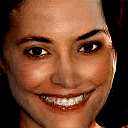

In [5]:
def interpolate_between_vectors():
  v1 = tf.random.normal([latent_dim])
  v2 = tf.random.normal([latent_dim])

  # Criar um tensor com 25 passos de interpolação entre v1 e v2.
  vectors = interpolate_hypersphere(v1, v2, 50)

  # Uso do modulo para gerar imagens para o espaço latente
  interpolated_images = progan(vectors)['default']

  return interpolated_images

interpolated_images = interpolate_between_vectors()
animate(interpolated_images)


## Encontrado o vetor mais próximo no espaço latente


Corrija uma imagem de destino. Como exemplo, use uma imagem gerada a partir do módulo ou carregue a sua própria.

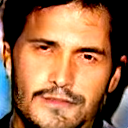

In [7]:
image_from_module_space = True # @param {isTemplate:true, type:"boolean"}

def get_module_space_image():
  vector = tf.random.normal([1, latent_dim])
  images = progan(vector)['default'][0]
  return images

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())])
  return transform.resize(images, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()

display_image(target_image)

Depois de definir uma função de perda entre a imagem alvo e a imagem gerada por uma variável de espaço latente, podemos usar a descida de gradiente para encontrar os valores das variáveis que minimizam a perda.

In [8]:
tf.random.set_seed(42)
initial_vector = tf.random.normal([1, latent_dim])

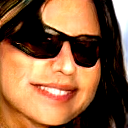

In [9]:
display_image(progan(initial_vector)['default'][0])

In [10]:
def find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image):
  images = []
  losses = []

  vector = tf.Variable(initial_vector)
  optimizer = tf.optimizers.Adam(learning_rate=0.01)
  loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

  for step in range(num_optimization_steps):
    if (step % 100) == 0:
      print()
    print('.', end='')
    with tf.GradientTape() as tape:
      image = progan(vector.read_value())['default'][0]
      if (step % steps_per_image) == 0:
        images.append(image.numpy())
      target_image_difference = loss_fn(image, target_image[:, :, :3])

# o vetor latente foi amostrado de uma distribuição normal. Podemos
# obter imagens mais realistas se regularizarmos o comprimento do vetor
# latente para o comprimento ou vetor médio desta distribuição.

      regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))

      loss = target_image_difference + regularizer
      losses.append(loss.numpy())
    grads = tape.gradient(loss, [vector])
    optimizer.apply_gradients(zip(grads, [vector]))
  return images, losses

num_optimization_steps = 200
steps_per_image = 5
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)




....................................................................................................
....................................................................................................

(0.0, 4881.122705078125)

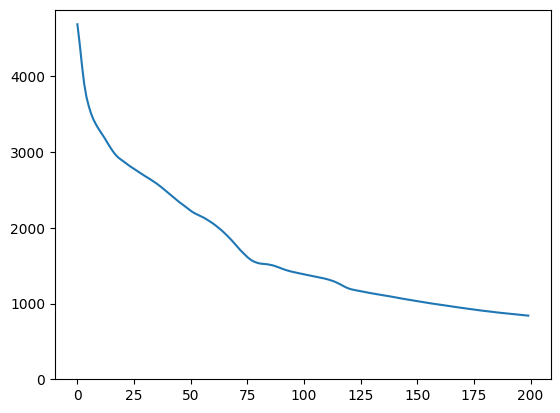

In [11]:
plt.plot(loss)
plt.ylim([0, max(plt.ylim())])


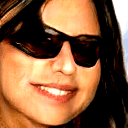

In [12]:
animate(np.stack(images))

Comparando o resultado com o alvo

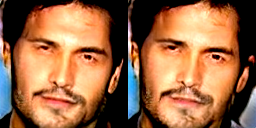

In [13]:
display_image(np.concatenate([images[-1], target_image], axis=1))

## Jogando com o exemplo acima

Se a imagem for do espaço do módulo, a descida é rápida e converge para uma amostra razoável.
Se for inserido uma imagem que não é do espaço módulo. A descida só convigirá se a imagem estiver razoavelmente próxima do espaço das imagens de treinamento.

Como fazer descer mais rápido e como uma imagem mais realista? Pode-se tentar:

- usando perda diferente na diferença de imagem, por exemplo,      quadrática.
- usando regulazador diferente no vetor latente,
- inicializando a partir de um vetor aleatório em várias execuções,
- etc.
